# Estimating the correlation length 

* The correlation length $L$ determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.
* This notebook can run on multiple CPU threads (see [01-notebooks-basics.ipynb](../1-Intro/01-notebooks-basics.ipynb))

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf

┌ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
└ @ Base loading.jl:1273


In [2]:
pathof(DIVAnd)

"/home/ctroupin/ULiege/Tools/divand.jl/src/DIVAnd.jl"

# Data reading

The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html). for the Provençal Basin (Mediterranean Sea). The profiles were not interpolated vertically.

The resulting correlation length can fluctuate a bit between runs, because the correlation is based on a collection of random pairs. 

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* Load the data file if it is not already present.

In [3]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else
    @info("Data file $filename already downloaded")
end


bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
bathisglobal = true
# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

┌ Info: Data file ../data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[3]:7
┌ Info: Bathymetry file already downloaded
└ @ Main In[3]:15


Load the data and print basic information about it that can be used for quality check.

In [4]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


It is quite important to remove outliers for the correlation length estimation, as outlires can have a significant impact.

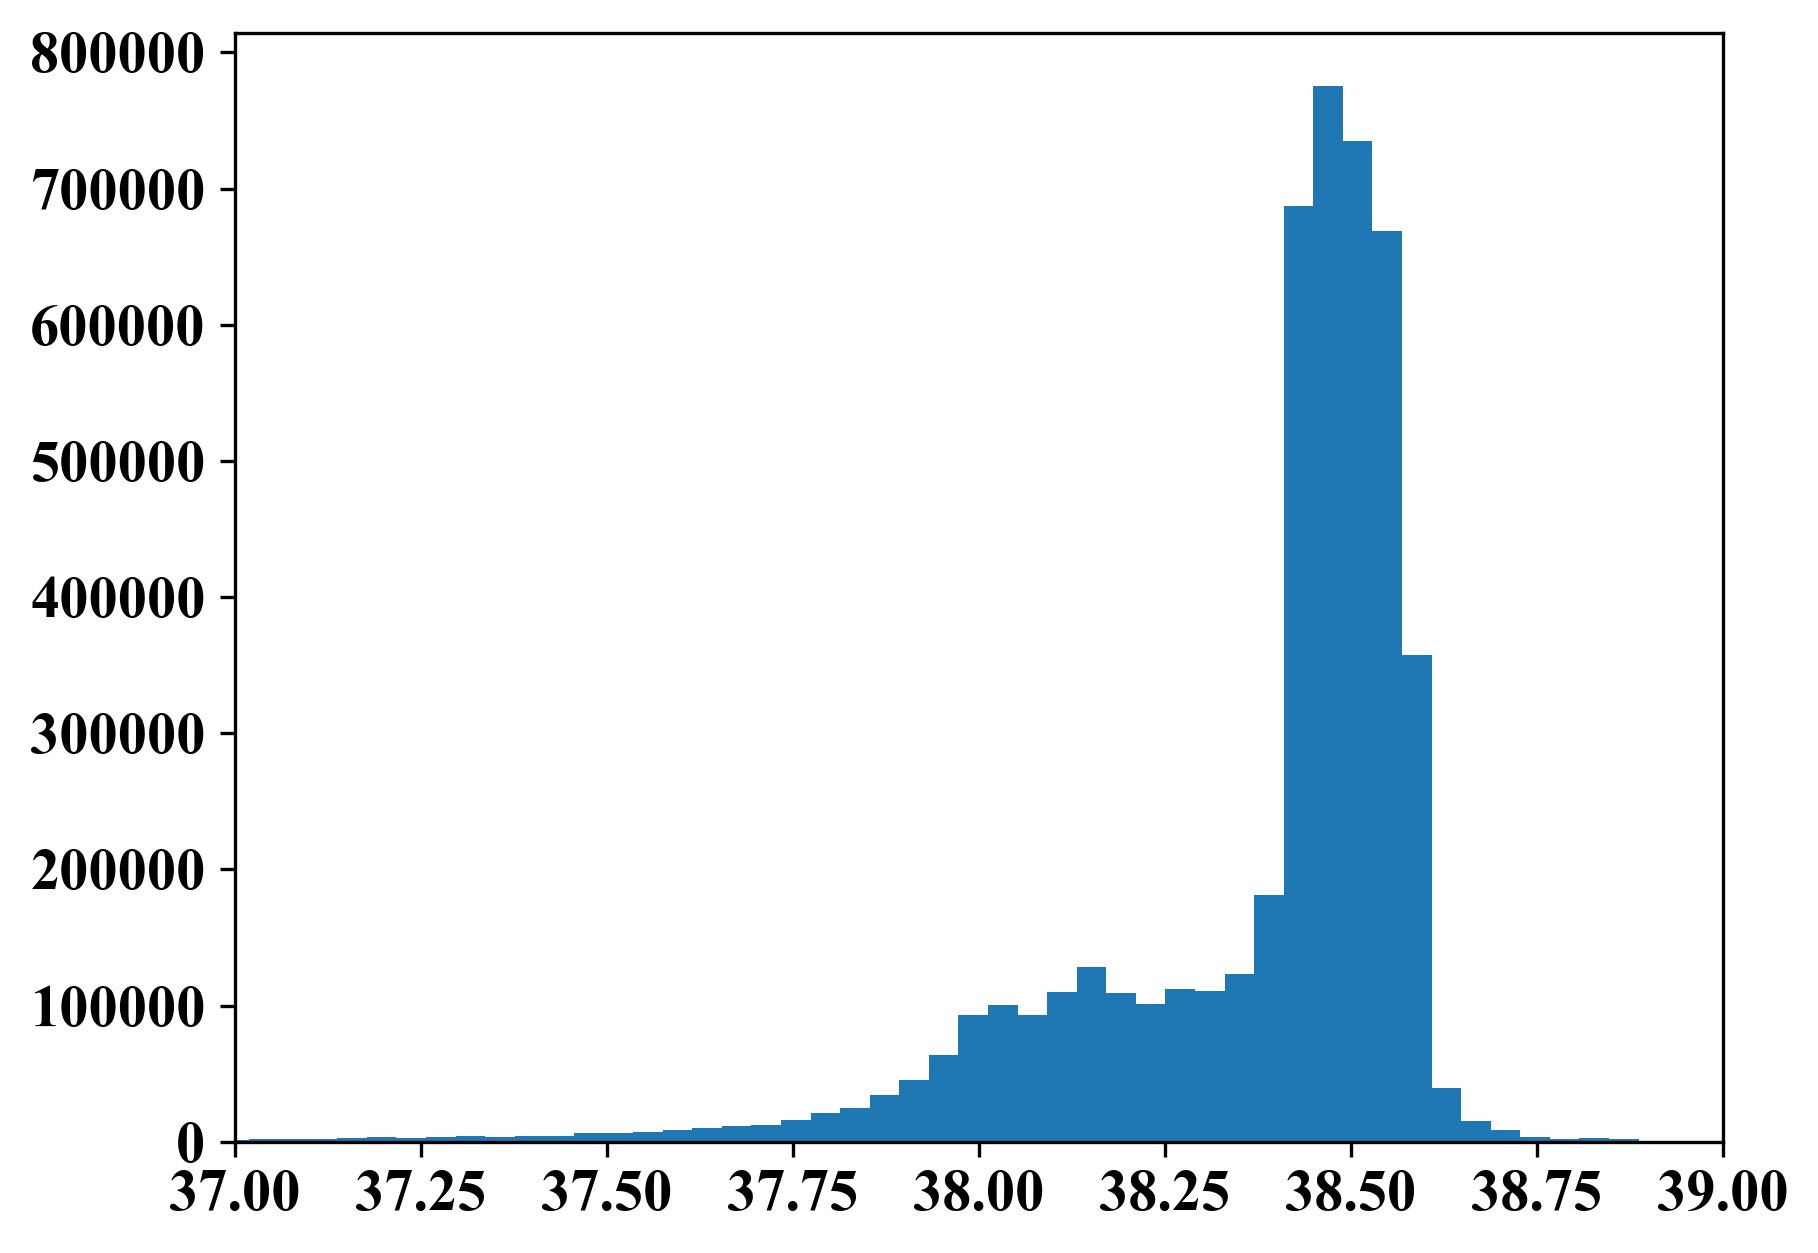

(37, 39)

In [5]:
hist(obsval,1000)
xlim(37,39)

For this example we select only the first month (January) and we remove some questionable data

In [6]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O","wod_015607117O","wod_015607524O","wod_015607893O","wod_015924970O","wod_015926914O","wod_015928739O","wod_016650545O", "wod_008518725O","wod_007643915O","wod_015875365O","wod_006614816O","wod_006614929O","wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O","wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O","wod_006752127O","wod_006752129O"]
good = (37.6 .< obsval .< 38.75) .& map(id -> !(id in badid),obsid)


sel = (Dates.month.(obstime) .== 1) .& good
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]

z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

#z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
#    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
#    275, 300, 350, 400, 450, 500, 550, 600];


Plot the observation at a given level. What do you think will happend if you run `plotobs.(z)`?

In [7]:
function plotobs(z)
    figure()
    sel = (Dates.month.(obstime) .== 1) .& (abs.(obsdepth .- z) .< 50)  .& good # .& (obsval .< 38.3)
    scatter(obslon[sel],obslat[sel],10,obsval[sel], cmap="jet"); colorbar(orientation = "horizontal");
    #print(join(map(s -> '"' * s * '"',String.(unique(obsid[sel]))),","))
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    aspectratio = 1/cos(mean(latr) * pi/180)
    gca().set_aspect(aspectratio)
    title("Depth: $z m")
end

plotobs (generic function with 1 method)

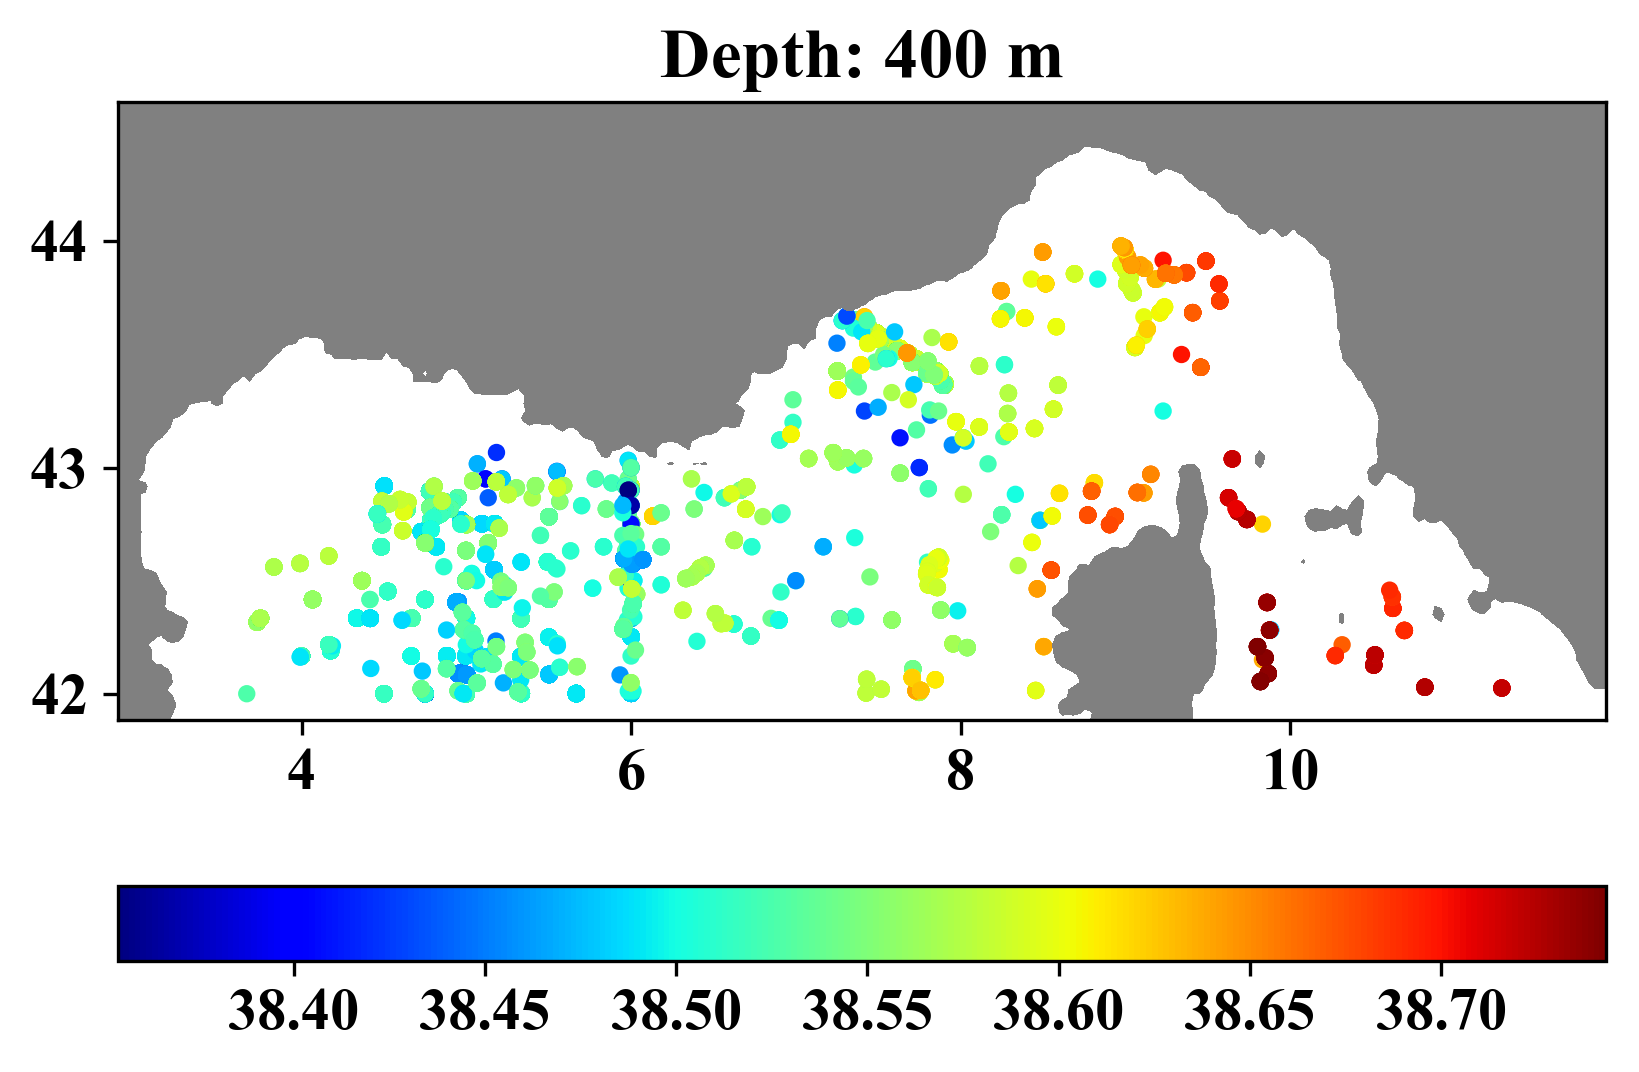

In [8]:
plotobs(400);

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [9]:
@time lenxy,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, searchz = z -> (z/4+10));

┌ Info: Data points at z=0.0: 3365, horz. correlation length: 16666.258916439838 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=112.0: 22553, horz. correlation length: 12220.379267156994 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=1150.0: 38137, horz. correlation length: 56047.500992626985 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=500.0: 32857, horz. correlation length: 210161.39822245485 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=5.0: 5739, horz. correlation length: 16764.154402248707 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=125.0: 23786, horz. correlation length: 11562.081447511404 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=10

┌ Info: Data points at z=1050.0: 39179, horz. correlation length: 71610.69187205889 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 15408.006995212763, )
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:895
┌ Info: Data points at z=2000.0: 29559, horz. correlation length: 15408.006995212763 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=1100.0: 38700, horz. correlation length: 39235.1028764853 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 14471.538167494806
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 14465.534278051377
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 14453.598157061946
└ @ DIVAnd /home/ctroupi

128.369575 seconds (2.53 G allocations: 75.712 GiB, 26.81% gc time)


Information about the fitting:


In [10]:
infoxy[:fitinfos][1]

Dict{Symbol,Any} with 8 entries:
  :sn          => 0.582371
  :rqual       => 0.90374
  :fitcovar    => [NaN, 0.0106974, 0.0102033, 0.00959847, 0.0089442, 0.00827595…
  :meandist    => 1.74699e5
  :covar       => [0.0145739, 0.0122097, 0.00966681, 0.00827608, 0.00766433, 0.…
  :range       => 2:23
  :distx       => 0.0:2183.7341347536476:705346.1255254282
  :covarweight => [1.07905e15, 1.07904e15, 1.07926e15, 1.07909e15, 1.07904e15, …

Extract the information for the level `k = 1`:
* `covar`: the empirical covariance
* `fitcovar`: the fitted empirical covariance
* `distx`: distance
* `range`: part of `covar` used for the fitting
* `rqual`: the quality for the fit (1: excellent, 0: poor)

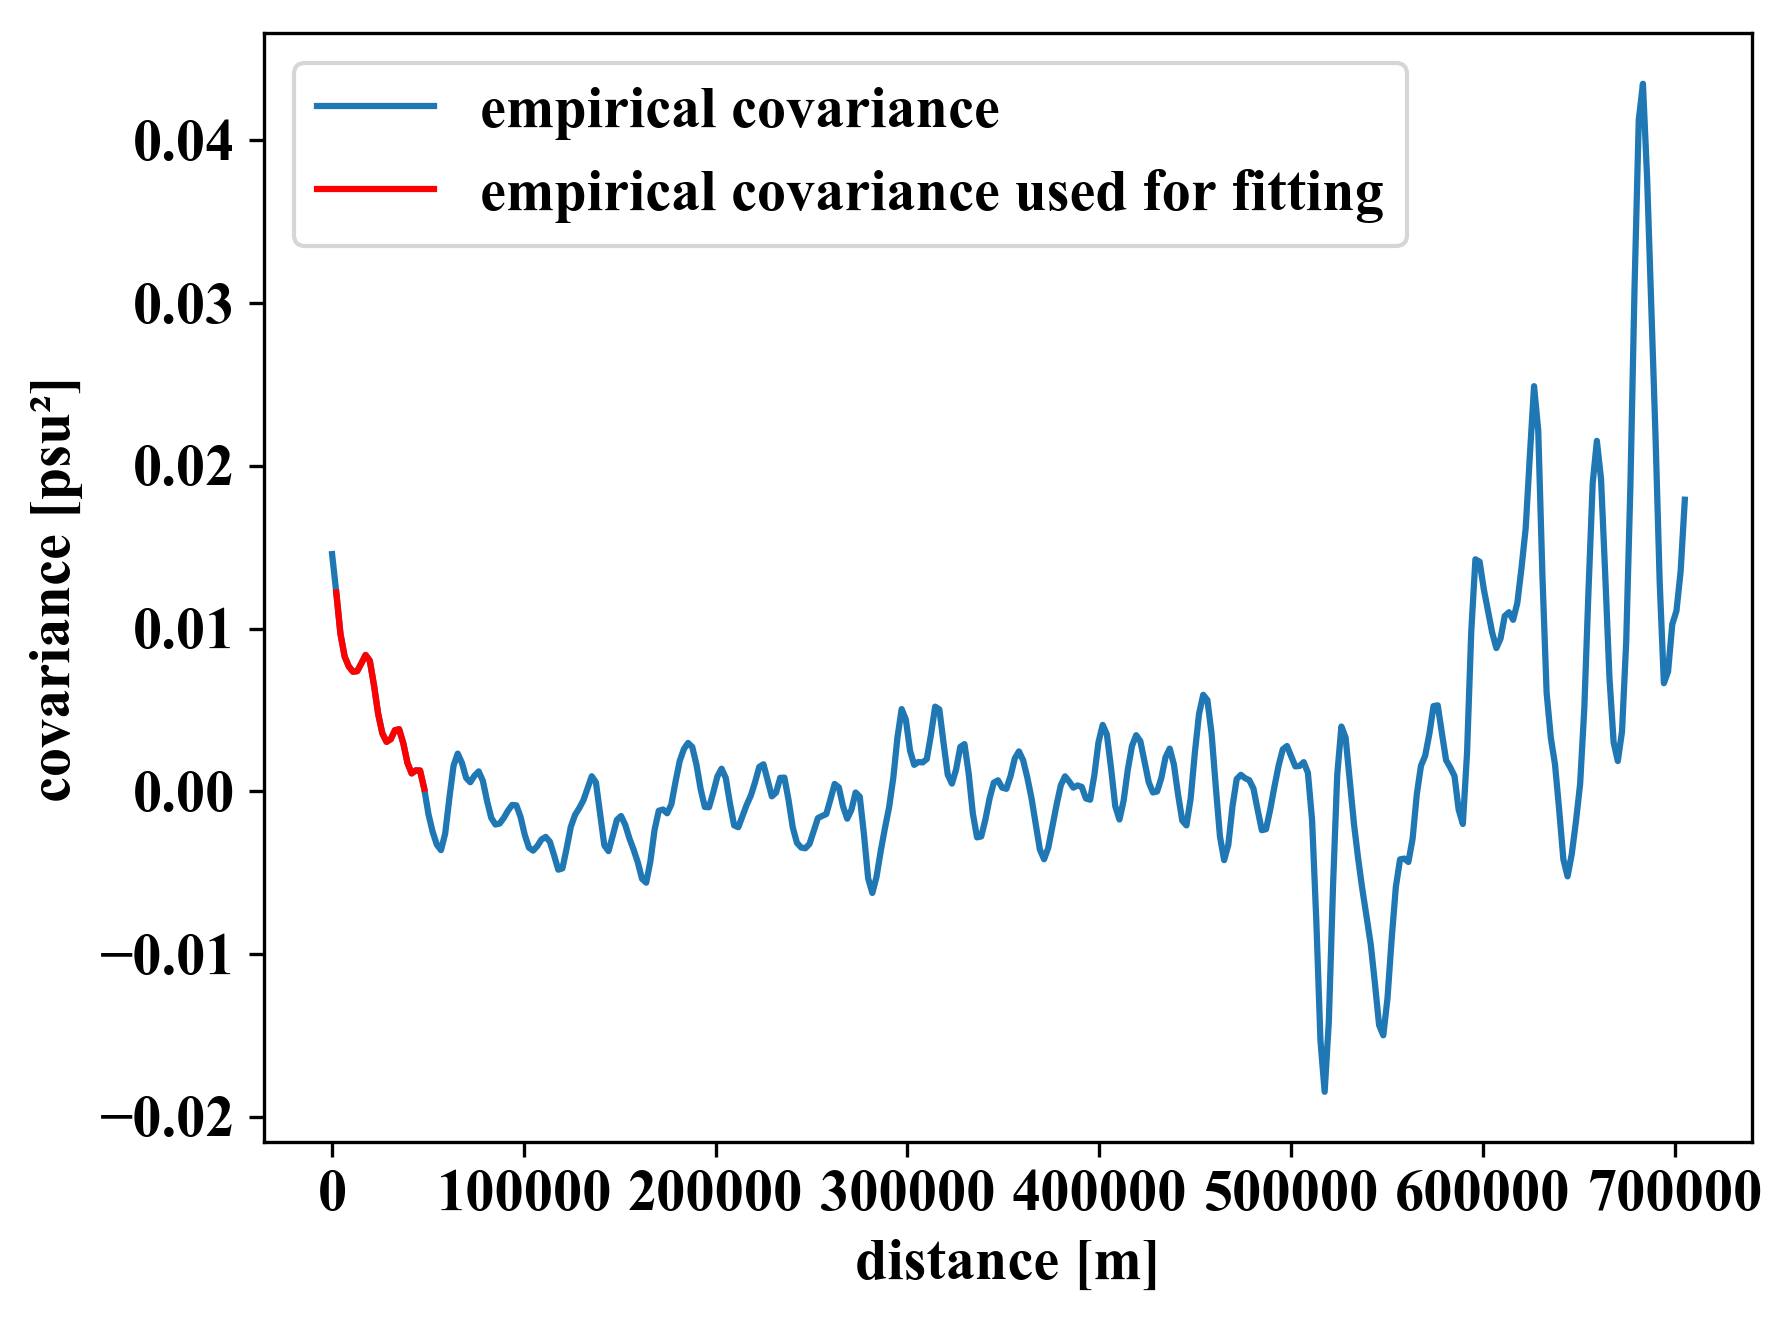

In [11]:
k = 1
covar = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx = infoxy[:fitinfos][k][:distx]
range = infoxy[:fitinfos][k][:range]
rqual = infoxy[:fitinfos][k][:rqual]

plot(distx,covar,label="empirical covariance")
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

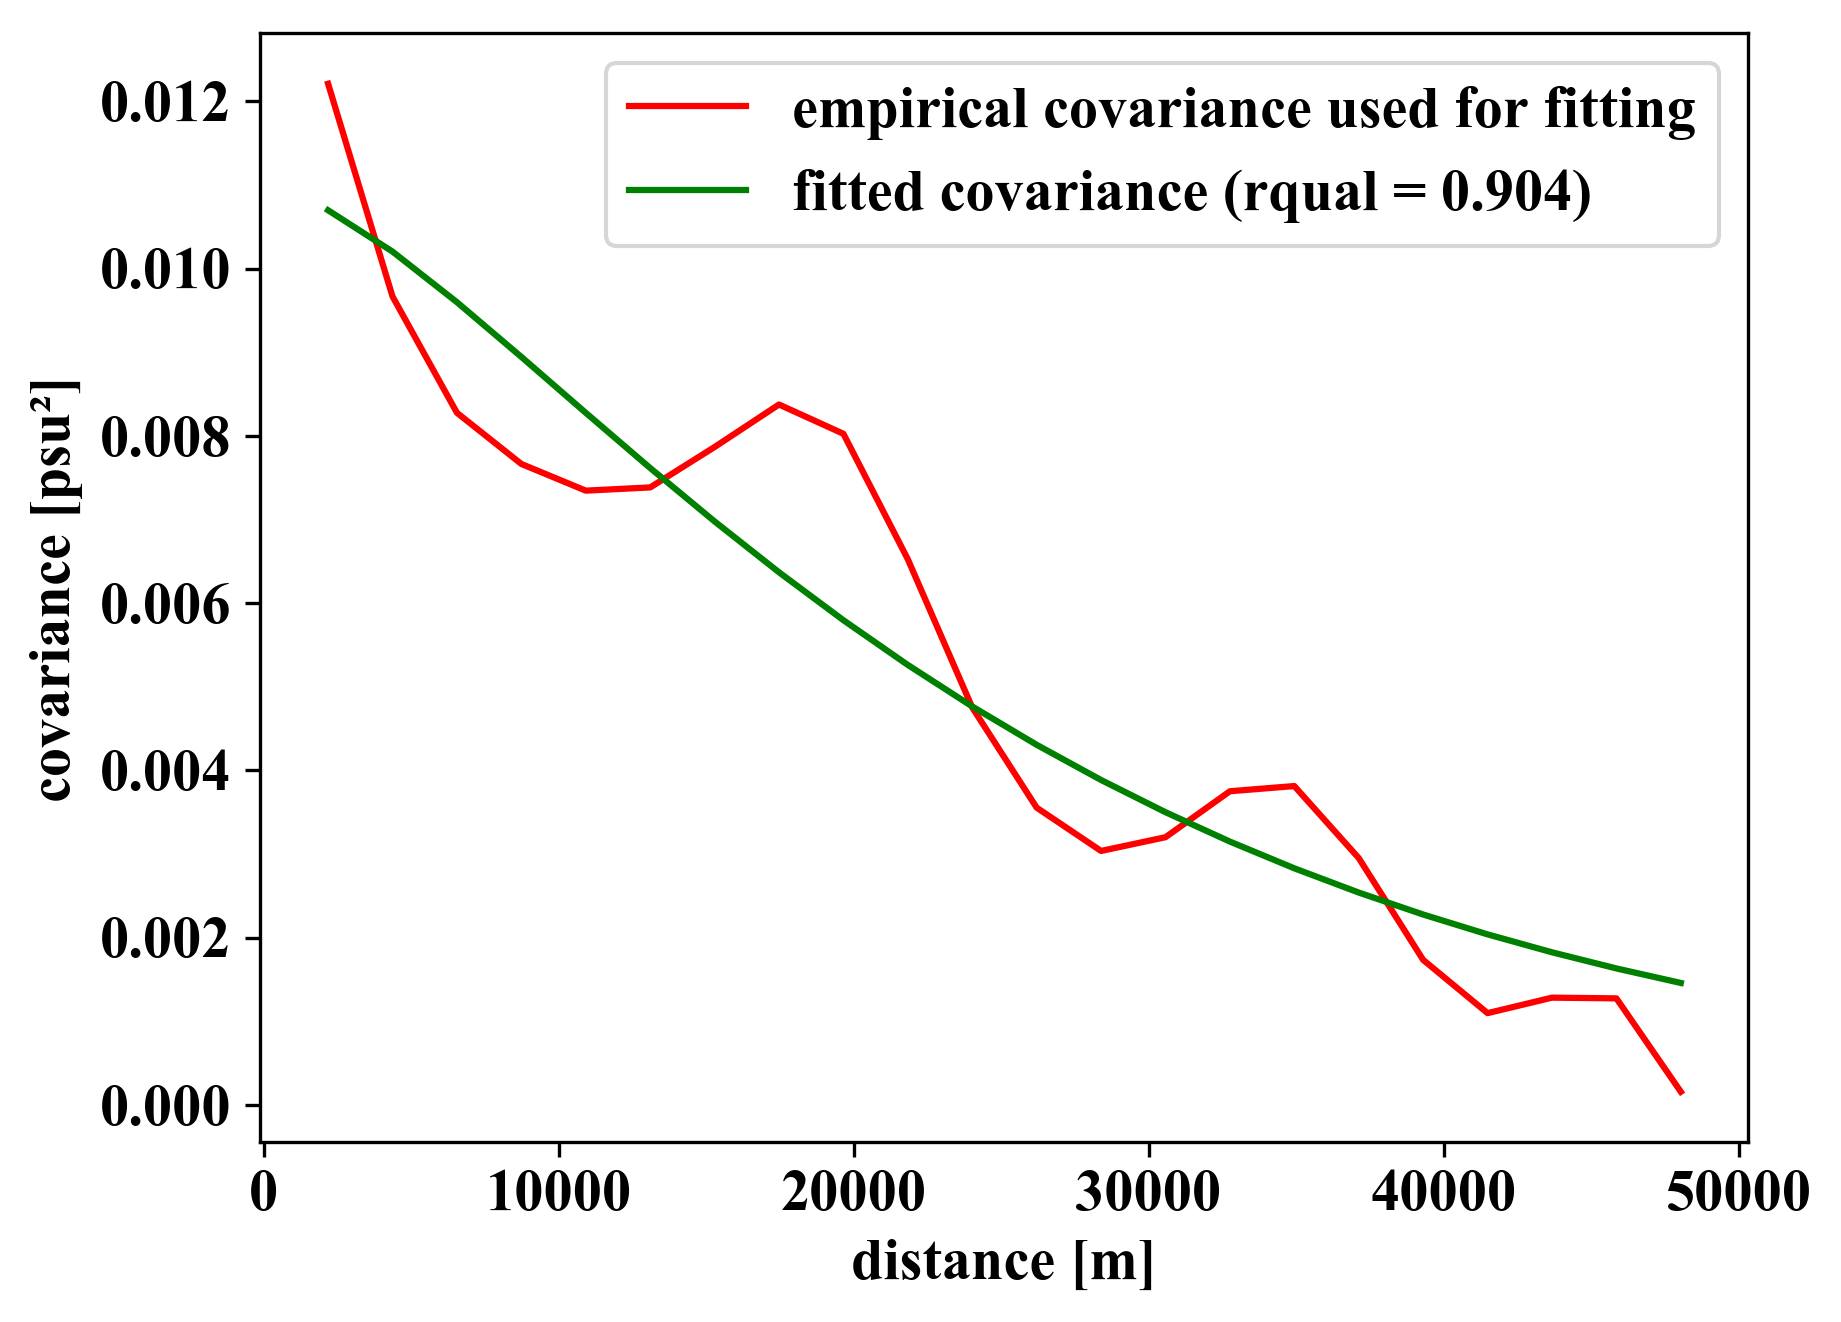

In [12]:
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
plot(distx[range],fitcovar[range],"g",label="fitted covariance (rqual = $(@sprintf("%4.3f",rqual)))")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

🖋️ Try different values of k (the level index) and re-run the previous two cells.     
Note that at some level the fit was quite poor. Additional filtering (vertically) is done to smooth the horizontal correlation length.

Make a plot of the horizontal correlation length with respect to the depth. 

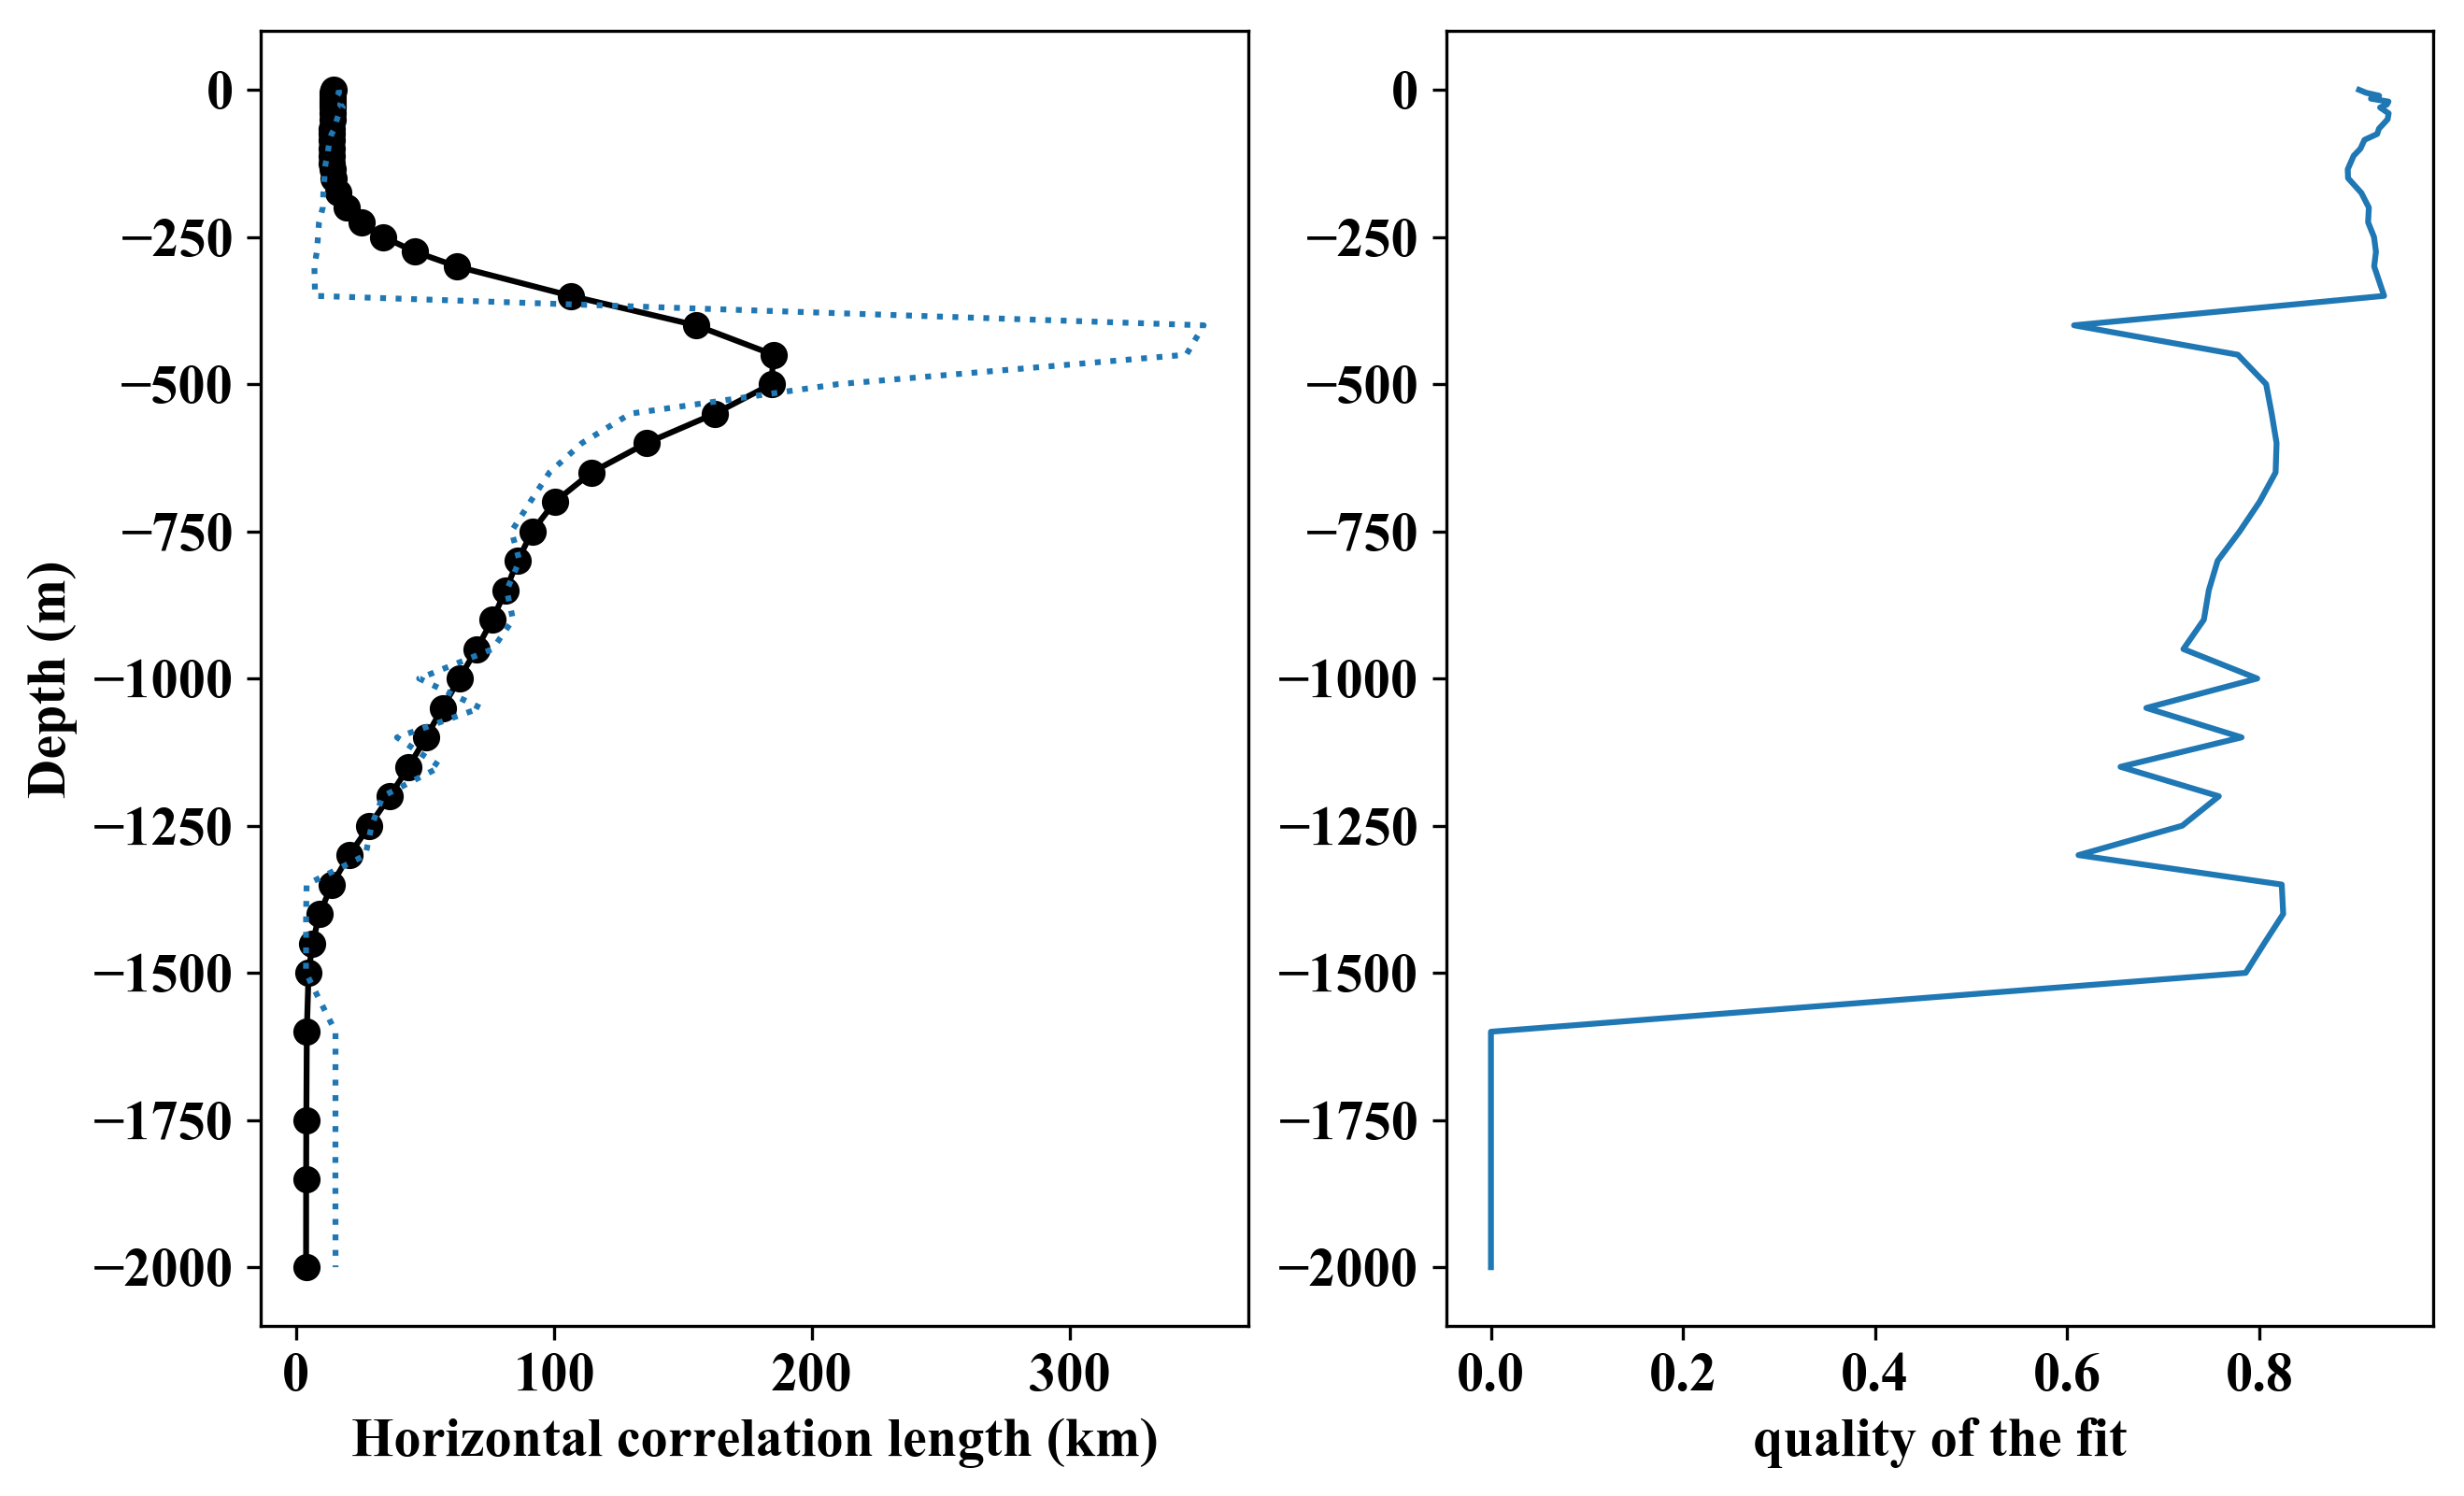

In [13]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenxy/1000,-z, "ko-")
plot(infoxy[:len]/1000,-z,":");
xlabel("Horizontal correlation length (km)")
ylabel("Depth (m)")
#xlim(0,180)
subplot(1,2,2)
plot(rqual,-z)
xlabel("quality of the fit");

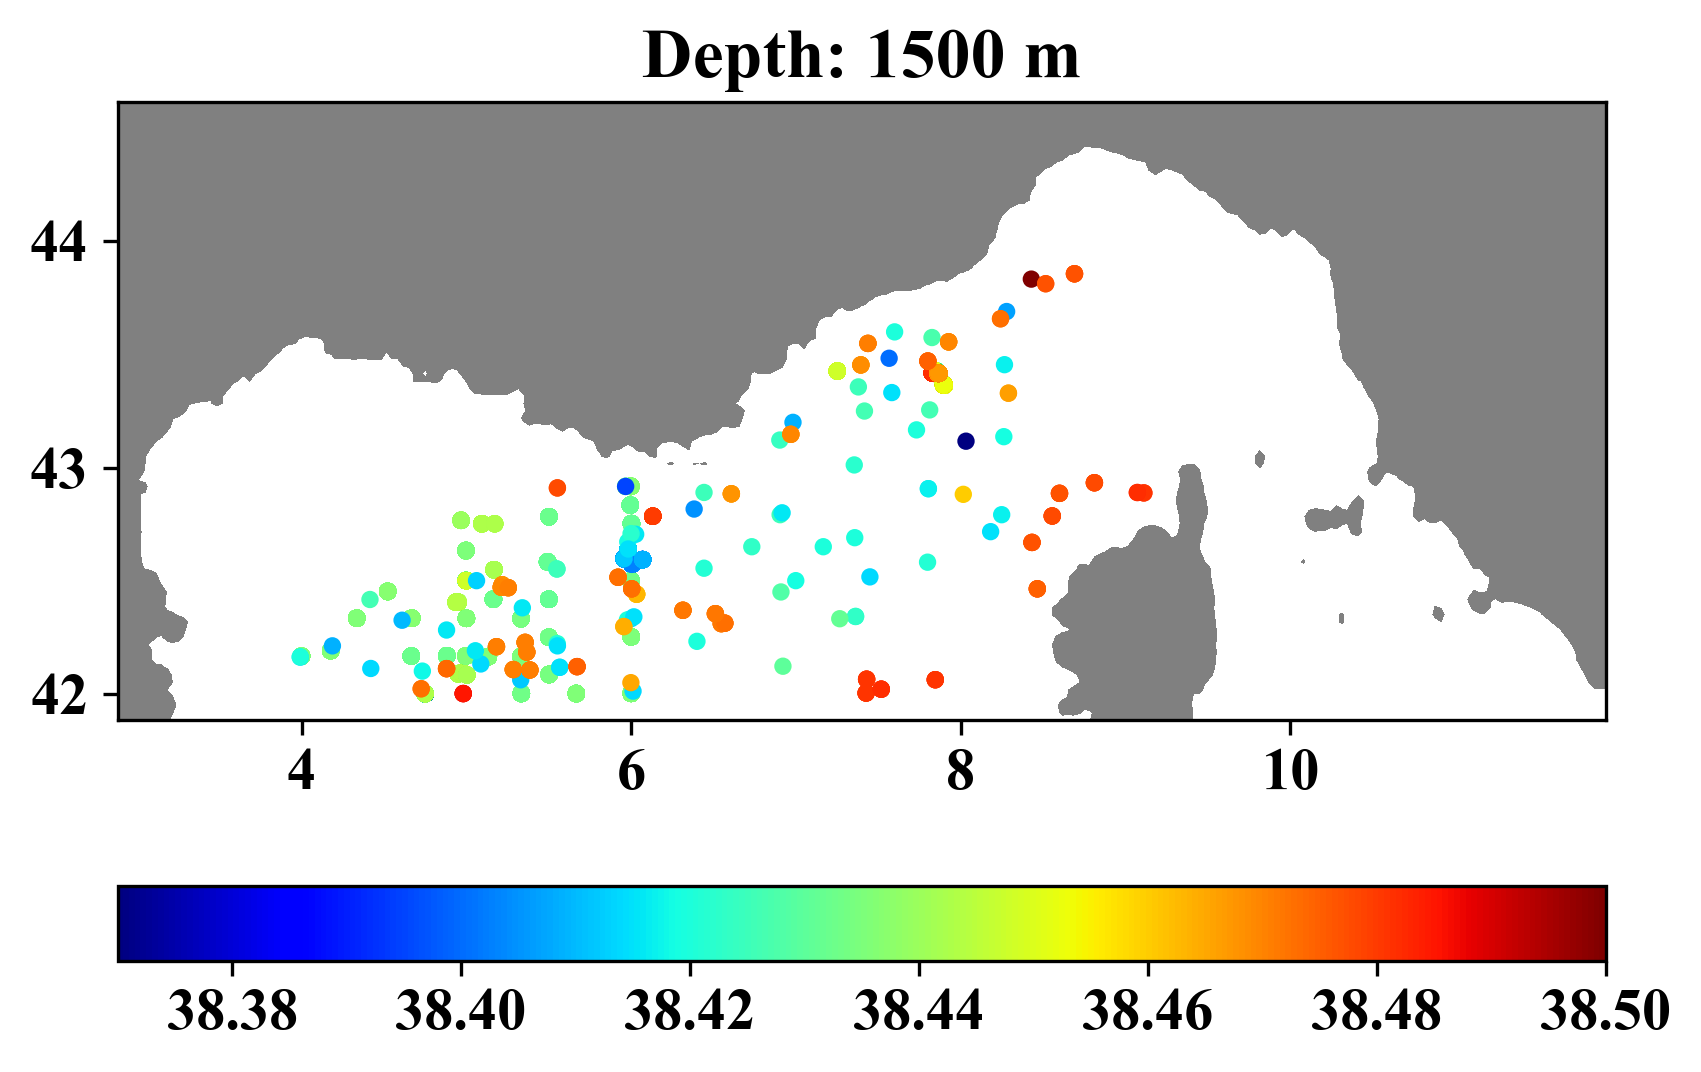

In [14]:
plotobs(1500);

It is useful to limit the acceptable range of the correlation length by providing a function `limitfun` with the argument depth `z` and estimated correlation length `len`. It the returns the adjusted correlation length. This adjustememt is done before the filtering.

In [15]:
@time lenxy2,infoxy2 = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, limitfun = (z,len) -> min(max(len,25e3),60e3));


┌ Info: Data points at z=1150.0: 5925, horz. correlation length: 273851.53993207176 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=112.0: 29790, horz. correlation length: 12297.865324479755 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=500.0: 11935, horz. correlation length: 185084.3023157528 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=0.0: 17698, horz. correlation length: 16644.774748761425 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=125.0: 28736, horz. correlation length: 11698.120078790464 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=1200.0: 5695, horz. correlation length: 10235.115659109524 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=

┌ Info: Data points at z=450.0: 12568, horz. correlation length: 237995.32023359288 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=1100.0: 6043, horz. correlation length: 86269.48009029838 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Data points at z=100.0: 30260, horz. correlation length: 12595.891359407848 (preliminary)
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 25005.90173701728
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 25006.097350455806
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 25006.493428685575
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=15.0: 25007.09974844648
└ @ DIVAnd /home/ctroupin/ULiege/

119.216635 seconds (2.48 G allocations: 74.013 GiB, 28.35% gc time)


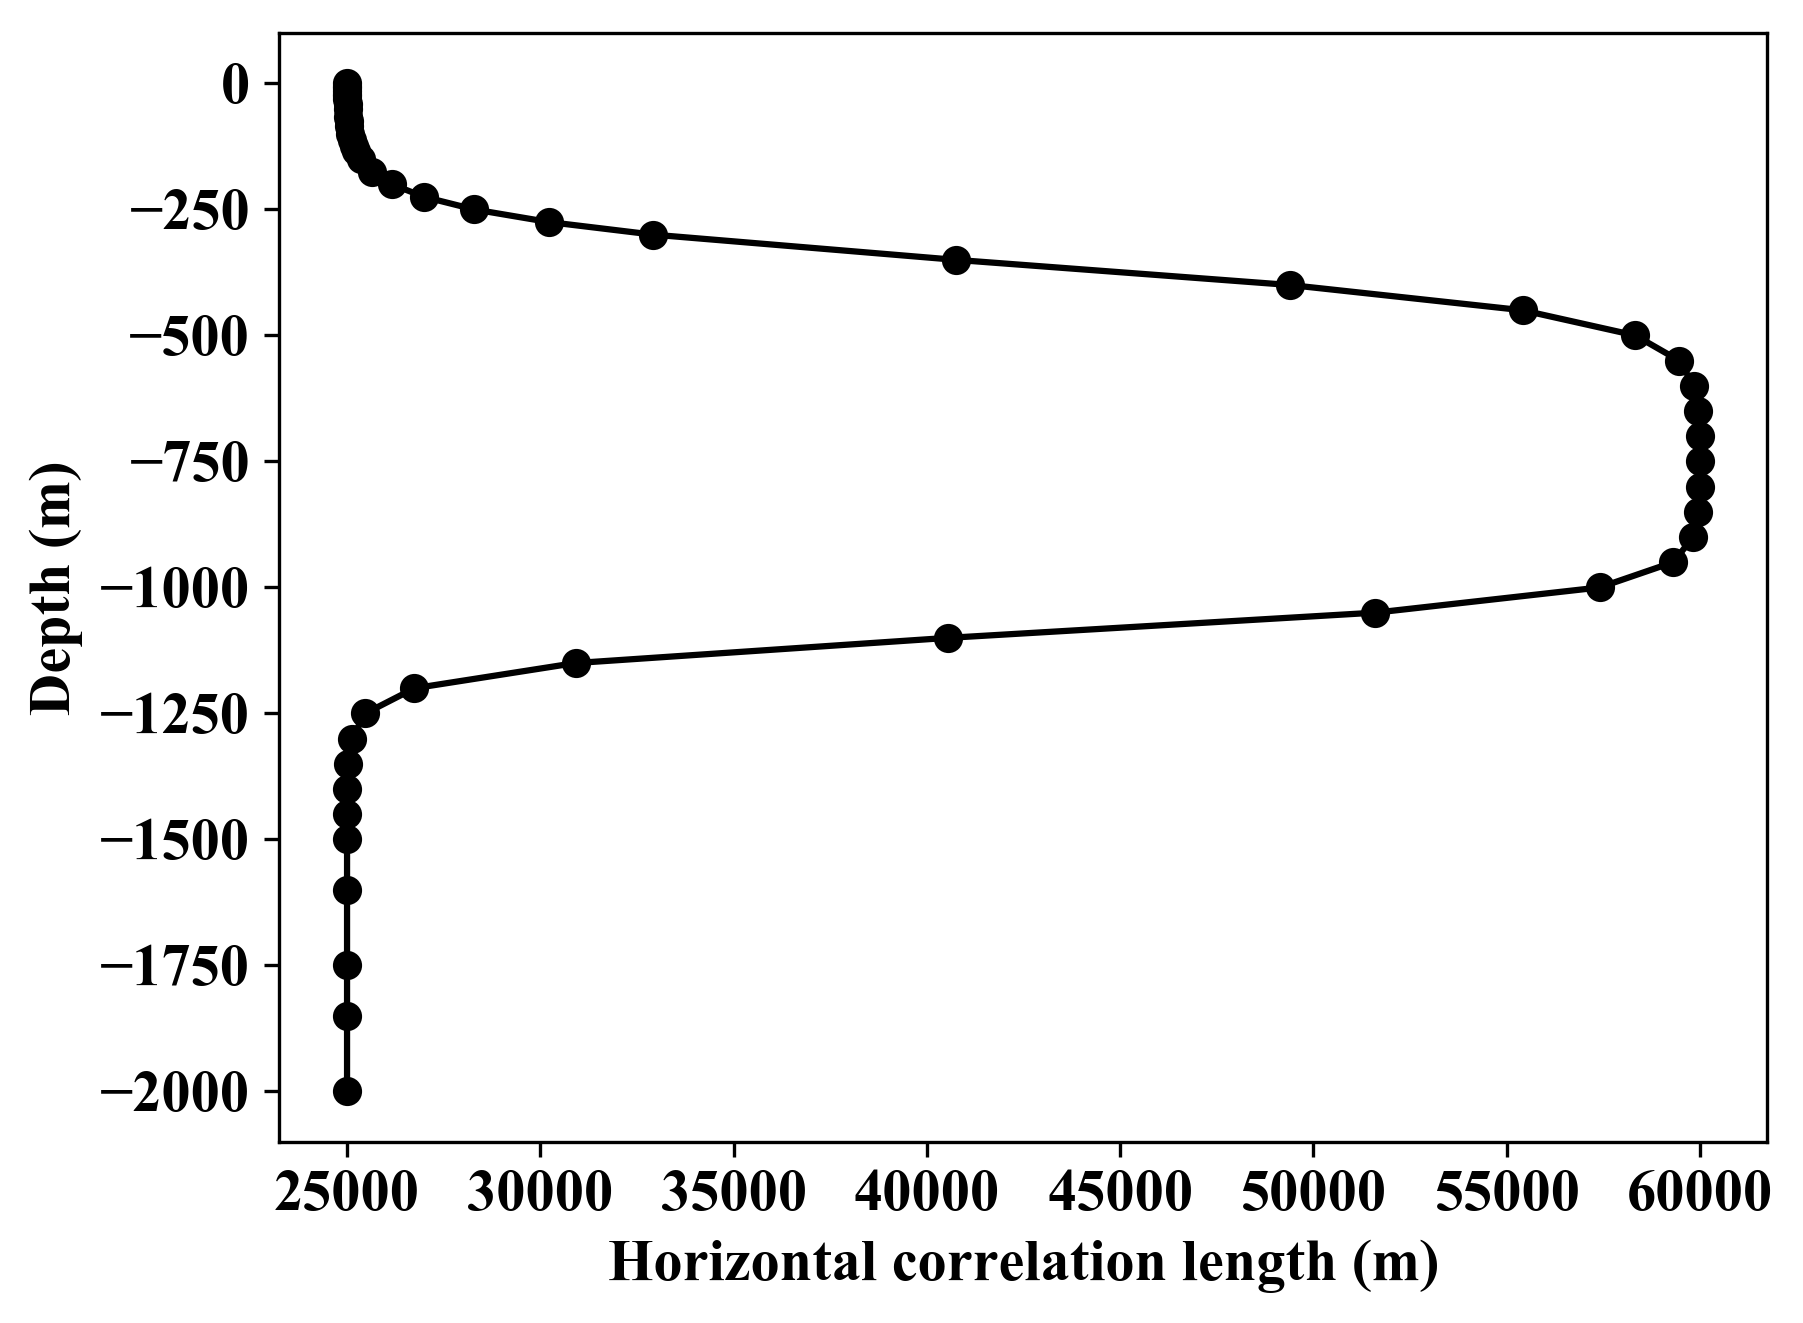

In [16]:
plot(lenxy2,-z, "ko-")
#plot(infoxy2[:len],-z,":");
xlabel("Horizontal correlation length (m)")
ylabel("Depth (m)");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [17]:
lenz,infoz = fitvertlen(x,v,z);

┌ Info: Vert. correlation length at z=0.0: 53.28
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=5.0: 55.02297600000001
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=10.0: 51.940944
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=15.0: 50.651721549316406
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 202.07999999999998, )
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:895
┌ Info: Vert. correlation length at z=20.0: 202.07999999999998
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=25.0: 48.098688
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit.jl:1177
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 197.68, )
└ @ DIVAnd /home/ctroupin/ULiege/Tools/divand.jl/src/fit

Make a plot

In [ ]:
infoz

In [ ]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenz,-z, "ko-")
plot(infoz[:len],-z, "-")
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");

subplot(1,2,2)
plot(rqual,-z, "b-");

An alternative is to use of the vertical coordinate to obtain a reasonable guess of the vertical correlation

In [ ]:
Dz = (z[3:end] - z[1:end-2])/2
lenz = 3 * [Dz[1], Dz..., Dz[end]]
lenzf = DIVAnd.smoothfilter(1:length(lenz),lenz,10)
plot(lenz,-z)
plot(lenzf,-z);